In [2]:
library(data.table)
load('../data/exonicvsnon_counts.rda') # Probabilities of each mutation type
load('../data/gene_pd_exon.rda') # Load tables giving probability of insertion for each gene in a diploid genome for both genders
source('./src_sompop_v0_2_4.r')
xy_genes <- gene_pd_m$gene_id[gene_pd_m$chrom %in% c('X','Y')] # Getting list of genes on chroms. X and Y by symbol`

In [3]:
geneList <- read.csv('../data/drivers_lusc.txt',header=F)
geneList <- geneList$V1

In [4]:
gene_pd_m[gene_pd_m$gene_id %in% geneList]
geneList <- gene_pd_m[gene_pd_m$gene_id %in% geneList]$gene_sym

chrom,gene_id,counts,length,type,gene_sym,p
1,ENSG00000009307,154.47598,5778,0,CSDE1,8.078662e-05
16,ENSG00000039068,122.14252,6177,0,CDH1,6.548150e-05
6,ENSG00000049618,1117.02732,44677,0,ARID1B,5.870627e-04
1,ENSG00000054118,116.80189,4736,0,THRAP3,6.145036e-05
7,ENSG00000055130,57.32418,3548,0,CUL1,3.137928e-05
10,ENSG00000060339,175.87414,6059,0,CCAR1,9.145919e-05
2,ENSG00000064012,219.51400,7243,0,CASP8,1.138344e-04
3,ENSG00000076242,51.61821,3532,0,MLH1,2.859215e-05
19,ENSG00000079432,31.39341,9494,0,CIC,2.471683e-05
5,ENSG00000095015,195.18470,7716,0,MAP3K1,1.024904e-04


### Define parameters

In [5]:
###################################################3
# Gender of organism
gender <- 'male'

# Symbol of driver gene disrupted at t=0
driverGene <- ''

# List of driver genes
geneList <- geneList

# Initial number of cells
N0 <- 1e3

# Average # L1 insertions / cell cycle
mu <- 1
if (gender=='male') {
    mu <- mu*(1-pd_exvsnon_m[2])# Scale by 1-probability of null (intron) insertion, to convert to probability of exonic insertion
} else if (gender=='female') {
    mu <- mu*(1-pd_exvsnon_f[2])
}

# Selective strengths of each mutation type
spd <- 0.1 # Homozygous driver
spp <- 0.005 # Homozygous passenger
sld <- spd*0.1 # Heterozygous driver
slp <- spp*0.1 # Hetero. passenger

# Number of time steps to simulate
NT <- 5e3

###################################################3
# Time resolution: number of timesteps per generation
tau <- 1
tau <- 1/tau
# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- N0*5
# Log path
logpath <- './test_v2.5.log'

## Test run

   user  system elapsed 
137.248   0.108 137.376 


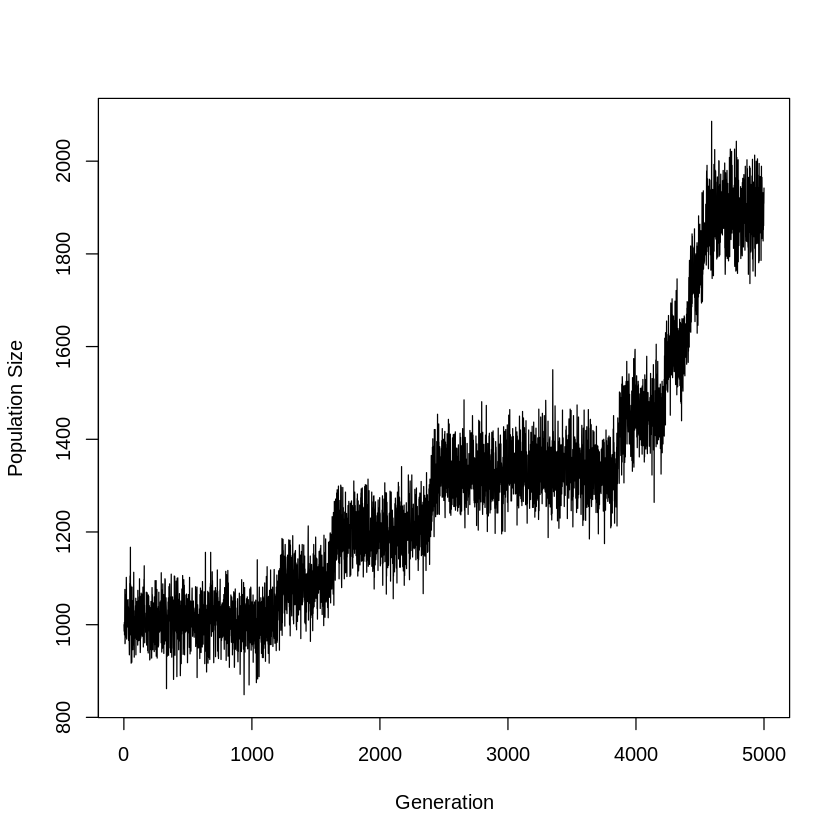

In [6]:
out <- sompop(N0, mu, tau, NT, sld, slp, spd, spp, gender, driverGene, geneList, maxNClones, logpath)
Pop <- out[[1]]
N <- out[[2]]
genTime <- out[[4]]

# head(Pop)
N[N==0] <- NA
genTime[genTime==0] <- NA
plot(1:NT*tau,N,type='l',xlab='Generation',ylab='Population Size')

In [7]:
head(Pop)

ncells,B,mu_i,nd_het,np_het,nd_hom,np_hom,genes_het,genes_hom
58,1.858076,0.02462650,3,155,7,0,", ENSG00000081138, ENSG00000151835, ENSG00000143776, ENSG00000213625, ENSG00000168395, ENSG00000174145, ENSG00000221818, ENSG00000080371, ENSG00000080815, ENSG00000112715, ENSG00000134146, ENSG00000167625, ENSG00000115091, ENSG00000064309, ENSG00000106355, ENSG00000165637, ENSG00000158258, ENSG00000147894, ENSG00000158711, ENSG00000160710, ENSG00000086570, ENSG00000053900, ENSG00000154978, ENSG00000247626, ENSG00000065320, ENSG00000141384, ENSG00000103222, ENSG00000081026, ENSG00000165490, ENSG00000285162, ENSG00000183530, ENSG00000197841, ENSG00000168679, ENSG00000141458, ENSG00000154783, ENSG00000154237, ENSG00000070269, ENSG00000180667, ENSG00000124422, ENSG00000104356, ENSG00000077232, ENSG00000102606, ENSG00000183020, ENSG00000129292, ENSG00000198862, ENSG00000215193, ENSG00000179889, ENSG00000128567, ENSG00000116521, ENSG00000104714, ENSG00000166710, ENSG00000188517, ENSG00000110077, ENSG00000183111, ENSG00000205277, ENSG00000112343, ENSG00000248592, ENSG00000198754, ENSG00000174173, ENSG00000160216, ENSG00000136717, ENSG00000151240, ENSG00000008513, ENSG00000075884, ENSG00000063176, ENSG00000110931, ENSG00000140795, ENSG00000103978, ENSG00000150261, ENSG00000160408, ENSG00000106278, ENSG00000163539, ENSG00000146263, ENSG00000146414, ENSG00000154359, ENSG00000141337, ENSG00000079950, ENSG00000080493, ENSG00000023909, ENSG00000140945, ENSG00000258659, ENSG00000152782, ENSG00000179598, ENSG00000136536, ENSG00000177728, ENSG00000105738, ENSG00000128052, ENSG00000006377, ENSG00000159251, ENSG00000126814, ENSG00000142065, ENSG00000167110, ENSG00000133739, ENSG00000136383, ENSG00000256463, ENSG00000011143, ENSG00000182670, ENSG00000111144, ENSG00000054219, ENSG00000115419, ENSG00000055483, ENSG00000197748, ENSG00000285542, ENSG00000109046, ENSG00000100836, ENSG00000103657, ENSG00000113558, ENSG00000081014, ENSG00000129493, ENSG00000196873, ENSG00000204923, ENSG00000166734, ENSG00000092345, ENSG00000134255, ENSG00000072274, ENSG00000156414, ENSG00000151665, ENSG00000262481, ENSG00000042980, ENSG00000065883, ENSG00000180875, ENSG00000124207, ENSG00000070814, ENSG00000116641, ENSG00000115310, ENSG00000198879, ENSG00000109452, ENSG00000085514, ENSG00000106692, ENSG00000138792, ENSG00000152495, ENSG00000166341, ENSG00000138101, ENSG00000205981, ENSG00000035928, ENSG00000172458, ENSG00000221978, ENSG00000172995, ENSG00000138772, ENSG00000137821, ENSG00000168779, ENSG00000197763, ENSG00000166387, ENSG00000103479, ENSG00000117505, ENSG00000075673, ENSG00000151893, ENSG00000266028, ENSG00000182247, ENSG00000130294, ENSG00000161970, ENSG00000267952, ENSG00000176142, ENSG00000178381, ENSG00000119547, ENSG00000089335, ENSG00000198542, ENSG00000114982",", ENSG00000112851, ENSG00000102081, ENSG00000215301, ENSG00000114126, ENSG00000205726, ENSG00000156531, ENSG00000177565"
45,1.859005,0.02462341,3,154,7,0,", ENSG00000081138, ENSG00000151835, ENSG00000143776, ENSG00000213625, ENSG00000168395, ENSG00000174145, ENSG00000221818, ENSG00000080371, ENSG00000080815, ENSG00000112715, ENSG00000134146, ENSG00000167625, ENSG00000115091, ENSG00000064309, ENSG00000106355, ENSG00000165637, ENSG00000158258, ENSG00000147894, ENSG00000158711, ENSG00000160710, ENSG00000086570, ENSG00000053900, ENSG00000154978, ENSG00000247626, ENSG00000065320, ENSG00000141384, ENSG00000103222, ENSG00000081026, ENSG00000165490, ENSG00000285162, ENSG00000183530, ENSG00000197841, ENSG00000168679, ENSG00000141458, ENSG00000154783, ENSG00000154237, ENSG00000070269, ENSG00000180667, ENSG00000124422, ENSG00000104356, ENSG00000077232, ENSG00000102606, ENSG00000183020, ENSG00000129292, ENSG00000198862, ENSG00000215193, ENSG00000179889, ENSG00000128567, ENSG00000116521, ENSG00000104714, ENSG00000166710, ENSG00000188517, ENSG00000110077, ENSG00000183111, ENSG00000205277, ENSG00000112343, ENSG00000248592, ENSG00000198754, ENSG00000174173, ENSG00000160216, ENSG00000136717, ENSG00000151240, ENSG

## Batch run

In [ ]:
nrun <- 0

N0v <- c(1e2,5e2,1e3)
muv <- c(0.05,0.1,0.5,1,5)
if (gender=='male') {
    muv_adj <- muv*(1-pd_exvsnon_m[2])
} else if (gender=='female') {
    muv_adj <- muv*(1-pd_exvsnon_f[2])
}
sdv <- c(0.001,.005,0.01,0.05,0.1,0.5,1)
spv <- c(0.001,.005,0.01,0.05,0.1,0.5,1)
hef <- 0.1 # Fraction of homozygous effect assigned to heterozygous mutations

outPath <- '~/jackgl/lusc_1115_3/'
logPath <- paste0(outPath,'run_1.log')
system(paste0('rm ',logPath))

tryCatch({
    for (ii in 1:length(N0v)){
        for (jj in 1:length(muv)) {
            for (ll in 1:length(sdv)) {
                for (mm in 1:length(spv)) {
                    for (nn in 1:5) {
                        nrun <- nrun+1
                        N0 <- N0v[ii]
                        mu <- muv_adj[jj]
                        sd <- sdv[ll]
                        sp <- spv[mm]
                        line <- paste0('Run: ',toString(nrun),'\tN0: ',toString(N0v[ii]),'\tmu: ',toString(muv[jj]),'\tsd: ',toString(sdv[ll]),'\tsp: ',toString(spv[mm]))
                        write(line,file=logPath,append=TRUE)
                        out <- sompop(N0, mu, tau, NT, sd*hef, sp*hef, sd, sp, gender, driverGene, geneList, N0v[ii]*4, logPath)
                        Pop <- out[[1]]
                        N <- out[[2]]
                        mut_genes <- out[[3]]
                        gen_time <- out[[4]]
                        save(Pop,N,mut_genes,gen_time,N0,mu,sd,sp,file=paste0(outPath,'run_n0',N0v[ii],'_',nrun,".rda"))
                        rm(Pop,N)
                    }
                }
            }
        }
    }
    }, warning = function(warn.msg){
        write(toString(warn.msg), logPath, append=TRUE)
    }, error = function(err.msg){
        write(toString(err.msg), logPath, append=TRUE)
    }
)